# Data Cleaning and Exploration

In [2]:
import sys
import sqlite3
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from collections import defaultdict

def get_data(filepath):
    '''
    Converts all database files in filepath into a single Dataframe
    Also converts columns into the correct data type
    
    Tests whether columns are correct data type
    Prints 'Dataframe is working intended' if data types are correct
    Return will be 2 DataFrames, the first one is the String values and the second one will be integer values
    
    Returns None if DataFrames are not in correct formats
    '''
    # 2 queries, one for string value and one for integer values
    appended_data_string = [] 
    appended_data_ull = []
    
    # loop through all files in test/testdata
    for filename in os.listdir(filepath):
        if filename == '.ipynb_checkpoints':
            continue
            
        # create the sql connection
        cnx = sqlite3.connect(filepath + filename)

        # read as dataframe, set 'MEASUREMENT_TIME' as date time object
        sub_df_string = pd.read_sql_query("SELECT * FROM COUNTERS_STRING_TIME_DATA", cnx)
        sub_df_ull = pd.read_sql_query("SELECT * FROM COUNTERS_ULL_TIME_DATA", cnx)

        # append "Start Row"
        first_row_string = sub_df_string.loc[0]
        new_row_string = pd.DataFrame({'MEASUREMENT_TIME': first_row_string[0], 'ID_INPUT': first_row_string[1], 'VALUE': 's0', 'PRIVATE_DATA': 0}, index =[0])
        sub_df_string = pd.concat([new_row_string, sub_df_string]).reset_index(drop=True)
        
        # append the informations
        appended_data_string.append(sub_df_string)
        appended_data_ull.append(sub_df_ull)

    # converting into 2 dataframes
    df_string = pd.concat(appended_data_string, ignore_index = True)
    df_ull = pd.concat(appended_data_ull, ignore_index = True)
    
    # preprocess the data
    df_string = preprocess(df_string)
    df_ull = preprocess(df_ull)
    
    # run tests on dataframe
    #if (test_dataframe_string(df_string) and test_dataframe_ull(df_ull)):
    #    return df_string, df_ull
    return df_string, df_ull
    # something went wrong!
    return None


def preprocess(df):
    '''
    Preprocess DataFrame so all data types are correct
    '''
    df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])
    df['PRIVATE_DATA'] = df['PRIVATE_DATA'].astype(int)
    
    return df

def test_dataframe_string(df):
    '''
    Checks whether the string DataFrame is in the correct format
    '''
    # get all dtypes
    dtypes = df.dtypes
    
    # columns should be date time, integer, string, then integer
    if dtypes[0] == '<M8[ns]' and dtypes[1] == 'int64' and dtypes[2] == 'object' and dtypes[3] == 'int64':
        return True
    
    return False
        

def test_dataframe_ull(df):
    '''
    Checks whether the ull DataFrame is in the correct format
    '''
    # get all dtypes
    dtypes = df.dtypes
    
    # columns should be date time, integer, integer, then integer
    if dtypes[0] == '<M8[ns]' and dtypes[1] == 'int64' and dtypes[2] == 'int64' and dtypes[3] == 'int64':
        return True
    
    return False

In [3]:
df_string, df_ull = get_data('test/testdata/')

In [57]:
df_string.head()

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2021-12-01 06:14:49.924,3,s0,0
1,2021-12-01 06:14:49.924,3,explorer.exe,0
2,2021-12-01 06:14:50.950,3,esrv.exe,0
3,2021-12-01 06:14:51.461,3,Teams.exe,0
4,2021-12-01 06:14:52.490,3,esrv.exe,0


In [4]:
df_string.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                       object
PRIVATE_DATA                 int32
dtype: object

In [5]:
df_ull.head()

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2021-12-01 06:14:48.902,0,1,0
1,2021-12-01 06:14:49.411,0,1,0
2,2021-12-01 06:14:48.902,1,657,0
3,2021-12-01 06:14:48.902,2,551,0
4,2021-12-01 06:14:49.923,0,1,0


In [6]:
df_ull.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                        int64
PRIVATE_DATA                 int32
dtype: object

In [7]:
df_string[df_string['ID_INPUT'] == 3]['VALUE'].value_counts()[:5]

chrome.exe      336
explorer.exe    243
Zoom.exe        174
Teams.exe       129
Discord.exe      97
Name: VALUE, dtype: int64

In [8]:
num_apps = len(df_string[df_string['ID_INPUT'] == 3]['VALUE'].unique())
print('Number of Applications: ' + str(num_apps))

Number of Applications: 55


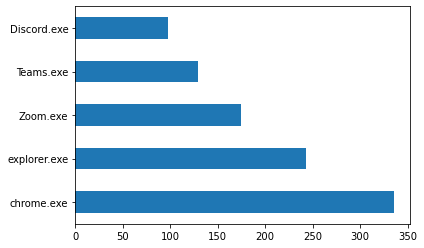

In [9]:
df_string[df_string['ID_INPUT'] == 3]['VALUE'].value_counts()[:5].plot.barh(x = 'index', y = 'VALUE')
plt.show()

In [10]:
df_string['VALUE'].value_counts()[-5:]

EADesktopInstaller.exe     1
XboxInstaller.exe          1
AccountsControlHost.exe    1
Steam.exe                  1
mcclauncher.exe            1
Name: VALUE, dtype: int64

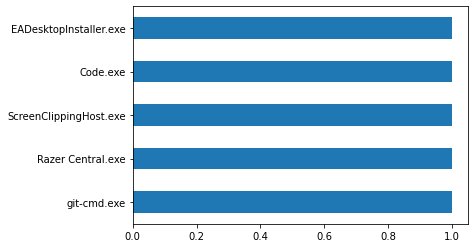

In [11]:
df_string[df_string['ID_INPUT'] == 3]['VALUE'].value_counts()[-5:].plot.barh(x = 'index', y = 'VALUE')
plt.show()

# Markov Model

In [4]:
# Only foreground data
df = df_string[df_string['ID_INPUT'] == 3] 

In [5]:
pairCount = defaultdict(int) # dict with unique senquential exe pairs being keys
allPairs = []
for i in range(df.shape[0]-1):
    pair = (df.iloc[i]['VALUE'], df.iloc[i+1]['VALUE'])
    allPairs.append(pair)
    pairCount[pair] += 1

In [8]:
from sklearn.model_selection import train_test_split

In [15]:
X = np.array([x[0] for x in allPairs])
y = np.array([x[1] for x in allPairs])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
pairCountTrain = defaultdict(int)
for i in range(len(X_train)):
    pair = (X_train[i], y_train[i])
    pairCountTrain[pair] += 1

In [19]:
pairProb = defaultdict(int)
for pair in pairCountTrain:
    b_count = sum(X_train == pair[0])
    pairProb[pair] = pairCountTrain[pair] / b_count # divides counts by number of pairs for the first exe ('B' in P(A|B))

In [20]:
pairProb

defaultdict(int,
            {('s0', 'explorer.exe'): 0.8275862068965517,
             ('explorer.exe', 'esrv.exe'): 0.0918918918918919,
             ('esrv.exe', 'Teams.exe'): 0.05128205128205128,
             ('Teams.exe', 'esrv.exe'): 0.009174311926605505,
             ('esrv.exe', 'explorer.exe'): 0.1282051282051282,
             ('Teams.exe', 'explorer.exe'): 0.29357798165137616,
             ('esrv.exe', 's0'): 0.6923076923076923,
             ('explorer.exe', 'notepad.exe'): 0.010810810810810811,
             ('notepad.exe', 'explorer.exe'): 0.5,
             ('explorer.exe', 'Teams.exe'): 0.13513513513513514,
             ('explorer.exe', 'chrome.exe'): 0.2972972972972973,
             ('chrome.exe', 'McUICnt.exe'): 0.02127659574468085,
             ('McUICnt.exe', 'chrome.exe'): 0.2727272727272727,
             ('chrome.exe', 'Zoom.exe'): 0.32269503546099293,
             ('Zoom.exe', 'chrome.exe'): 0.4491017964071856,
             ('Zoom.exe', 'Discord.exe'): 0.04790419161676

In [21]:
# Validation
# All Probabilities for each "B" add up to one showing we made the pairs and probabilties correctly
exes = df['VALUE'].unique()
for e in exes:
    pairs = []
    for k in pairProb.keys(): # gets pairs for each exe
        if k[0] == e:
            pairs.append(k)
    sum_prob = 0
    for p in pairs: # adds all the probabilities together
        sum_prob += pairProb[p]
    if sum_prob != 1.0:
        print('Exe: ' + str(e) + '\t\tTotal Probability: ' + str(sum_prob))      

Exe: s0		Total Probability: 0.9999999999999998
Exe: explorer.exe		Total Probability: 0.9999999999999996
Exe: chrome.exe		Total Probability: 0.9999999999999998
Exe: Discord.exe		Total Probability: 0.9999999999999998
Exe: ShellExperienceHost.exe		Total Probability: 0.9999999999999998
Exe: Admin App		Total Probability: 0.9999999999999999
Exe: SystemSettings.exe		Total Probability: 0.9999999999999999
Exe: steamwebhelper.exe		Total Probability: 0.9999999999999999
Exe: TS4_x64.exe		Total Probability: 0
Exe: Taskmgr.exe		Total Probability: 0
Exe: ScreenClippingHost.exe		Total Probability: 0
Exe: Razer Synapse 3.exe		Total Probability: 0
Exe: Razer Central.exe		Total Probability: 0
Exe: git-cmd.exe		Total Probability: 0


In [25]:
def getPred(numExe, start='s0'):
    """Predicts laptop foreground window for a specfied number of exe and starting exe"""
    pred = [start]
    for action in range(numExe-1):
        prev = pred[-1]
        max_prob = 0
        new_exe = ''
        for k in pairProb.keys(): # Finds the most likely following exe given the previous
            if k[0] == prev and pairProb[k] > max_prob:
                new_exe = k[1]
                max_prob = pairProb[k]
        pred.append(new_exe) 
    return pred

In [9]:
getPred(7) # default start

['s0', 'explorer.exe', 'chrome.exe', 'Zoom.exe', 'chrome.exe', 'Zoom.exe', 'chrome.exe']


In [10]:
getPred(5, 'DB Browser for SQLite.exe')

['DB Browser for SQLite.exe', 'explorer.exe', 'chrome.exe', 'Zoom.exe', 'chrome.exe']


In [11]:
getPred(4, 'steamwebhelper.exe')

['steamwebhelper.exe', 'steam.exe', 'steamwebhelper.exe', 'steam.exe']


In [38]:
outcome = []
for i in range(len(X_test)):
    pred = getPred(2, X_test[i])
    outcome.append(pred[1] == y_test[i])

In [39]:
np.sum(outcome) / len(outcome)

0.16981132075471697

# Matrix

In [104]:
all_exe = df['VALUE'].unique() # gather all unique .exe
prob = [] # vlaues for dataframe


# i = event B
for i in all_exe:
    temp_list = []
    # j = event A
    for j in all_exe:
        exe_set = (i, j) # create a set
        try: # see if the set is in one of the pairings
            temp_list.append(pairProb[exe_set])
        except: # if set is not in pairing, then the probability is 0
            temp_list.append(0)

    prob.append(temp_list)

prob_matrix = pd.DataFrame(prob, index = all_exe, columns = all_exe)

In [53]:
allExe = set(np.concatenate((X_train, y_train)))
prob =[]

for exe in allExe:
    temp_list = []
    for exe2 in allExe:
        pair = (exe, exe2)
        try: # see if the set is in one of the pairings
            temp_list.append(pairProb[pair])
        except: # if set is not in pairing, then the probability is 0
            temp_list.append(0)
            
    prob.append(temp_list)

prob_matrix = pd.DataFrame(prob, index = allExe, columns = allExe)   

In [105]:
prob_matrix.head()

,s0,explorer.exe,esrv.exe,Teams.exe,notepad.exe,chrome.exe,McUICnt.exe,Zoom.exe,Discord.exe,ShellExperienceHost.exe,...,EADesktopInstaller.exe,EADesktop.exe,Peggle.exe,Installer.exe,TS4_x64.exe,Taskmgr.exe,ScreenClippingHost.exe,Razer Synapse 3.exe,Razer Central.exe,git-cmd.exe
s0,0.000000,0.827586,0.034483,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0,0,0,0,0,0
explorer.exe,0.005405,0.005405,0.091892,0.135135,0.010811,0.297297,0.000000,0.124324,0.070270,0.021622,...,0.0,0.005405,0.0,0.005405,0,0,0,0,0,0
esrv.exe,0.692308,0.128205,0.000000,0.051282,0.000000,0.025641,0.000000,0.025641,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0,0,0,0,0,0
Teams.exe,0.000000,0.293578,0.009174,0.000000,0.000000,0.403670,0.027523,0.018349,0.045872,0.009174,...,0.0,0.000000,0.0,0.000000,0,0,0,0,0,0
notepad.exe,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0,0,0,0,0,0


# Markov Experimentation

In [106]:
converter = list(prob_matrix.columns)

In [107]:
fullTrain = []
for i in range(len(X_train)):
    fullTrain.append(converter.index(X_train[i]))
    fullTrain.append(converter.index(y_train[i]))
fullTrain = np.array(fullTrain).reshape(-1, 1)

In [111]:
fullTest = []

for i in range(len(X_test)):
    fullTest.append(converter.index(X_test[i]))
    fullTest.append(converter.index(y_test[i]))
        
fullTest = np.array(fullTest).reshape(-1, 1)

In [130]:
from hmmlearn import hmm

model = hmm.GaussianHMM()
model.fit(fullTrain)
model.predict(fullTest)

Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [125]:
model.transmat_

array([[1.]])